# Vision Transformer

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [33]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 2
BATCH_SIZE = 32
EPOCHS = 100
IMG_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE)**2
SHUFFLE_SIZE = 1000

#ViT Hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
projection_dim = 64
attn_heads = 10
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
# Size of the transformer layers
transformer_layers = 2
# Size of the dense layers of the final classifier
mlp_head_units = [2048, 1024, 512]  

## Data Gathering and Spliting

In [1]:
#Getting Dataset from Storage
dataset = tf.keras.utils.image_dataset_from_directory(
    'Dataset',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
)
class_names = dataset.class_names

NameError: name 'tf' is not defined

In [35]:
#Function to split dataset into train, validation and test
def split_dataset(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=SHUFFLE_SIZE):
    ds_size = len(ds)
    
    if(shuffle):
        ds.shuffle(shuffle_size, seed = 12345)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_data = ds.take(train_size)
    val_data = ds.skip(train_size).take(val_size)
    test_data = ds.skip(train_size).skip(val_size)
    
    return train_data,val_data,test_data

In [36]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [37]:
AUTOTUNE = tf.data.AUTOTUNE
#Spliting Dataset and Optimizing for TF_Pipeline
train_ds, val_ds, test_ds = split_dataset(dataset, train_split=0.6,val_split=0.3)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Visualization

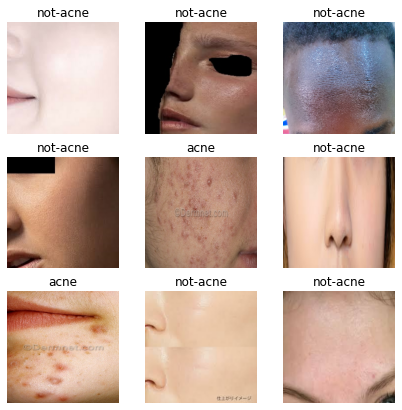

In [38]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Preprocessing and Augumentation

In [39]:
#Resizing is set here for images from user
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
#Data Augumentation
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Normalization(),
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(height_factor=0.3, width_factor = 0.3, fill_mode='constant')
    ],
    name="data_augmentation",
)

## Augumented Data Visualization

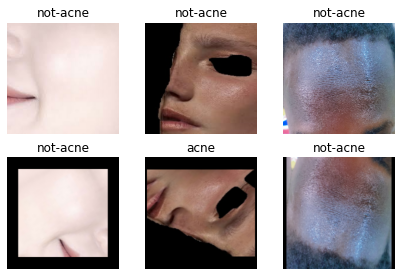

In [40]:
original_images = images[:3]
aug_images = data_augumentation(original_images)
imgs = np.vstack((original_images.numpy(),aug_images.numpy()))

plt.figure(figsize=(7, 7))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i].astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# The ViT Architecture

## Defining Patches Class as a Keras Layer

In [41]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Patches Visualization

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


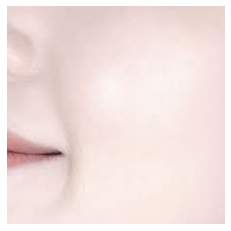

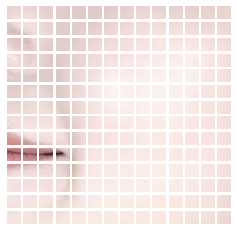

In [42]:
patches = Patches(PATCH_SIZE)(images)

print(f"Image size: {IMG_SIZE} X {IMG_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

plt.figure(figsize=(4, 4))
plt.imshow(images[0].numpy().astype("uint8"))
plt.axis("off")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch Encoding Class to transform Patches and Add Positional Information

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Defining the MultiLayer Perceptron

In [ ]:
def mlp(x, hidden_layers, dropout_rate):
    for hidden_layer in hidden_layers:
        x = layers.Dense(hidden_layer, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## ViT Classifier

In [ ]:
#Creating Keras ViT model using Keras FunctionalAPI
def vit_classifier():
    inputs = layers.Input(shape=INPUT_SHAPE)
    #Data Augumentation and Preprocessing
    resize_rescale_images = resize_rescale(inputs)
    augmented = data_augumentation(resize_rescale_images)
    #SPlit Image into Patches
    patches = Patches(PATCH_SIZE)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(NUM_PATCHES, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        #Multi-head attention layer 1.
        attention_output1 = layers.MultiHeadAttention(
            num_heads=attn_heads,
            key_dim=projection_dim,
            value_dim=projection_dim,
            dropout=0.1
        )(encoded_patches, encoded_patches)
        # Skip connection 1.
        x1 = layers.Add()([attention_output1, encoded_patches])
        # Layer normalization 1.
        norm_x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        
        #Multi-head attention layer 2.
        attention_output2 = layers.MultiHeadAttention(
            num_heads=attn_heads,
            key_dim=projection_dim,
            value_dim=projection_dim,
            dropout=0.1
        )(norm_x1, norm_x1)
        # Skip connection 2.
        x2 = layers.Add()([attention_output2, norm_x1])
        # Layer normalization 2.
        norm_x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP.
        mlp_head = mlp(norm_x2, hidden_layers=transformer_units, dropout_rate=0.1)
        # Skip connection 3.
        encoded_patches = layers.Add()([mlp_head, norm_x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    #representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_layers=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
""" checkpoint_filepath = '/tmp/checkpoint'
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
)"""
def train_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

   


    model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        #callbacks=[checkpoint_callback],
    )

"""model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")"""

## Training Model

In [ ]:
vit_classifier = vit_classifier()
train_model(vit_classifier)